##WILDFIRE DETECTION TASK
a binary classification problem to decide the presence of wildfire or no wildfire in the image dataset available on kaggle

##1. Importing Dataset and Libraries
Importing a publicly available dataset of wildfire images from kaggle using token of kaggle.

###1. importing dataset in a google colab file

In [1]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raviaijaz","key":"12fcad00579141d1e565f4c177f14f12"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 97% 1.41G/1.45G [00:11<00:00, 167MB/s]
100% 1.45G/1.45G [00:11<00:00, 133MB/s]


In [5]:
#extracting the datasets files inside a data folder
!unzip /content/wildfire-prediction-dataset.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: data/valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: data/valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: data/valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: data/valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: data/valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: data/valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: data/valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: data/valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: data/valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: data/valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: data/valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: data/valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: data/valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: data/valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: data/val

###2. importing dataset in a jupyter notebook

In [ ]:
!pip install kaggle
import os
import shutil
import zipfile

kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)
shutil.copy(r'C:/Users/ravia.ijaz/Desktop/kaggle.json', os.path.join(kaggle_dir, 'kaggle.json'))

os.chmod(os.path.join(kaggle_dir, 'kaggle.json'), 0o600)

!kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset

with zipfile.ZipFile('wildfire-prediction-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')  # Extracts into a folder named "data"


Importing all the necessary libraries required for the model building, training and testing

In [7]:
!pip install tensorflow          #using tensorflow for model training instead of pytorch

In [8]:
#for model building
from PIL import ImageFile   #to load truncated files if any in the dataset
from PIL import Image       #to load an image file
import hashlib     #to find the duplicate images using hasing
import os     #deleting garbage data files
from collections import Counter         #to count the images in the datasets
import seaborn as sns                #for visualization
import matplotlib.pyplot as plt         #for visualization

# Using TensorFlow libraries for model training
from tensorflow.keras.preprocessing.image import ImageDataGenerator          #for data preprocessing
from tensorflow.keras.models import Sequential             #for a custom sequential model building
from keras.applications import VGG16            #loading pretrained model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam    #loading the optimizer for model training
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D     #importing layers of CNN from keras

#for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve      #importing evaluation metrics for the model

##2. Data Cleaning
Our dataset constains RGB images of wildfire from a satellite. For the data cleaning process, we will be removing images which are duplicate, corrupt or truncated as they will cause errors during the training of the model

In [9]:
# loading all the truncated/corrupt images in the dataset

ImageFile.LOAD_TRUNCATED_IMAGES = True

# model was first trained with the truncated images and the training failed in between
# because some of the images in the dataset were corrupt or truncated. Hence, this is one of the challenges
# faced during the model training process, so I have to remove the corrupt images from the dataset to avoid errors during the training of the model

In [10]:
# Function to find and remove duplicate images
def find_duplicates(directory):
    hashes = {}
    duplicates = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                path = os.path.join(root, file)
                with open(path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                if file_hash in hashes:
                    duplicates.append(path)
                else:
                    hashes[file_hash] = path
    return duplicates

duplicates = find_duplicates('data/')
print(f"Duplicate images found: {len(duplicates)}")

#removing the duplicate images
for dup in duplicates:
    os.remove(dup)

Duplicate images found: 34


In [11]:
# finding and removing the corrupt images which are unable to load and open
def remove_corrupt_images(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except Exception as e:
                    print(f"Removing corrupted image: {file_path}")
                    os.remove(file_path)

#removing corrupt images from all the three sets of dataset
remove_corrupt_images("data/train")
remove_corrupt_images("data/valid")
remove_corrupt_images("data/test")


##3. Data Preprocessing

No need of splitting data into training and testing sets as it is already splitted into train, test and validation set

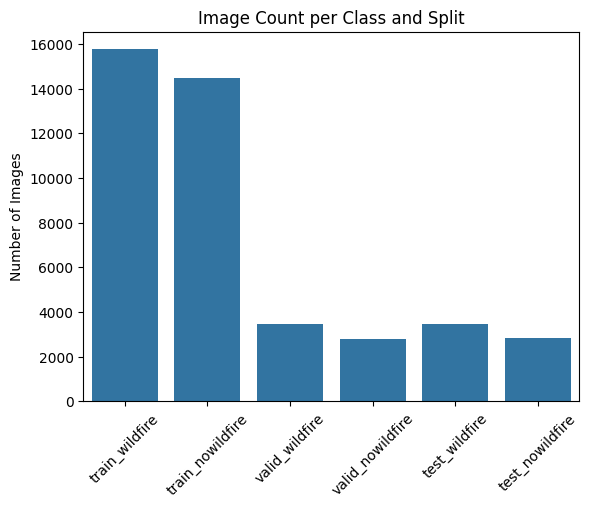

In [12]:
# finding the statistics of images in each class and set of the dataset using visualization
def count_images_per_class(directory):
    class_counts = {}
    for subset in ['train', 'valid', 'test']:
        subset_path = os.path.join(directory, subset)
        for cls in ['wildfire', 'nowildfire']:
            class_path = os.path.join(subset_path, cls)
            count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
            class_counts[f"{subset}_{cls}"] = count
    return class_counts

counts = count_images_per_class('data')
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.xticks(rotation=45)
plt.title('Image Count per Class and Split')
plt.ylabel('Number of Images')
plt.show()


In [13]:
#using image data generator class from tensorflow to preprocess, augment and rescale the data

train_datagen = ImageDataGenerator(
    rescale=1./255,   # scaling pixels on the range of [0, 1]
    horizontal_flip=True,      #using data augmentation for generalization
    rotation_range=15,             #using another augmentation technique
    preprocessing_function=lambda x: (x - 0.5) * 2    #normalizing the pixels to [-1, 1] from [0, 1]
)

test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: (x - 0.5) * 2
)

train = train_datagen.flow_from_directory(
    "data/train/",
    class_mode="binary",         #Binary classification problem because of two classes only
    shuffle=True,
    batch_size=128,            #dividing the data into batches
    target_size=(350, 350)      #resizing images to same dimension
)

val = test_val_datagen.flow_from_directory(
    "data/valid/",
    class_mode="binary",
    shuffle=False,
    batch_size=128,
    target_size=(350, 350)
)

test = test_val_datagen.flow_from_directory(
    "data/test/",
    class_mode="binary",
    shuffle=False,
    batch_size=128,
    target_size=(350, 350)
)

Found 30222 images belonging to 2 classes.
Found 6294 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


##4. Modeling

###1. Custom CNN Model

In [14]:
# designing the architecture of custom CNN Model
model = Sequential()
model.add(InputLayer(shape=(350, 350, 3)))

model.add(Conv2D(25, (5, 5), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())         #for faster training and stability of the model

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))                   #to avoid overfitting
model.add(Dense(1, activation='sigmoid'))   #using sigmoid activation function as it is a binary classification problem

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 350, 350, 25)   │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 175, 175, 25)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 50)     │        31,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 44, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 70)     │        31,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 70)     │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8470)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       847,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,551 (3.52 MB)

 Trainable params: 922,311 (3.52 MB)

 Non-trainable params: 240 (960.00 B)

In [15]:
# Training the model on train and validation sets for 5 epochs
history = model.fit(train, epochs=5, validation_data=val)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 893s 4s/step - accuracy: 0.8967 - loss: 0.2870 - val_accuracy: 0.8093 - val_loss: 0.5622
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 864s 4s/step - accuracy: 0.9392 - loss: 0.1636 - val_accuracy: 0.8985 - val_loss: 0.2431
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 863s 4s/step - accuracy: 0.9429 - loss: 0.1488 - val_accuracy: 0.8364 - val_loss: 0.8079
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 862s 4s/step - accuracy: 0.9576 - loss: 0.1147 - val_accuracy: 0.9485 - val_loss: 0.1599
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 862s 4s/step - accuracy: 0.9592 - loss: 0.1113 - val_accuracy: 0.9558 - val_loss: 0.1273


In [16]:
print("Train loss:", history.history['loss'])
print("Val loss:", history.history['val_loss'])
print("Train acc:", history.history['accuracy'])
print("Val acc:", history.history['val_accuracy'])


Train loss: [0.22306722402572632, 0.15796783566474915, 0.13802552223205566, 0.11802578717470169, 0.11232730001211166]
Val loss: [0.5621797442436218, 0.24305419623851776, 0.8078617453575134, 0.1599234938621521, 0.12731139361858368]
Train acc: [0.9191317558288574, 0.9406392574310303, 0.9478194713592529, 0.9564224481582642, 0.9582092761993408]
Val acc: [0.8093422055244446, 0.8984747529029846, 0.8363521099090576, 0.9485223889350891, 0.9558309316635132]


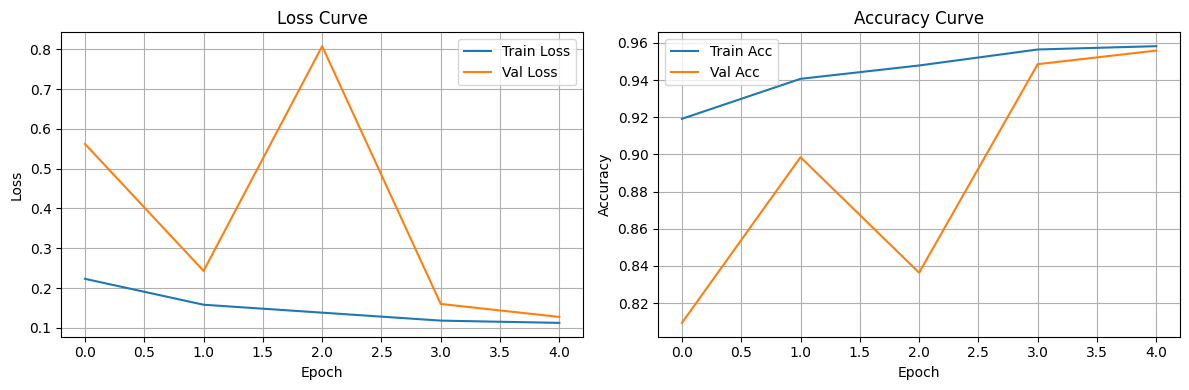

In [17]:
# visulaizing the difference in training and validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()

# visulaizing the difference in training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

###2. Transfer Learning using a Pretrained Model VGG16

In [ ]:
# include top should be False to remove the softmax layer
base_model = VGG16(weights='imagenet', include_top = False, input_shape=(350, 350, 3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 350, 350, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 350, 350, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 175, 175, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 175, 175, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 175, 175, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 87, 87, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 87, 87, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 87, 87, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 87, 87, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 43, 43, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 43, 43, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 43, 43, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 43, 43, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 21, 21, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Adding a custom classifier layer to make it a binary classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Traininng the custom layer of pretrained model
history = model.fit(train, epochs=5, validation_data=val)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1239s 5s/step - accuracy: 0.7512 - loss: 0.5133 - val_accuracy: 0.9122 - val_loss: 0.2347
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1058s 4s/step - accuracy: 0.9047 - loss: 0.2478 - val_accuracy: 0.9231 - val_loss: 0.1919
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1060s 4s/step - accuracy: 0.9200 - loss: 0.2074 - val_accuracy: 0.9311 - val_loss: 0.1772
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1058s 4s/step - accuracy: 0.9270 - loss: 0.1928 - val_accuracy: 0.9371 - val_loss: 0.1653
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 1059s 4s/step - accuracy: 0.9295 - loss: 0.1903 - val_accuracy: 0.9409 - val_loss: 0.1578


In [ ]:
print("Train loss:", history.history['loss'])
print("Val loss:", history.history['val_loss'])
print("Train acc:", history.history['accuracy'])
print("Val acc:", history.history['val_accuracy'])

Train loss: [0.3935874402523041, 0.23474198579788208, 0.20493939518928528, 0.19255995750427246, 0.18532274663448334]
Val loss: [0.234704852104187, 0.1919296234846115, 0.17718708515167236, 0.16528698801994324, 0.1578492522239685]
Train acc: [0.841798722743988, 0.9098309278488159, 0.9209159016609192, 0.9280301928520203, 0.9320670962333679]
Val acc: [0.9121525287628174, 0.9231135845184326, 0.9310563802719116, 0.9370929598808289, 0.9409054517745972]


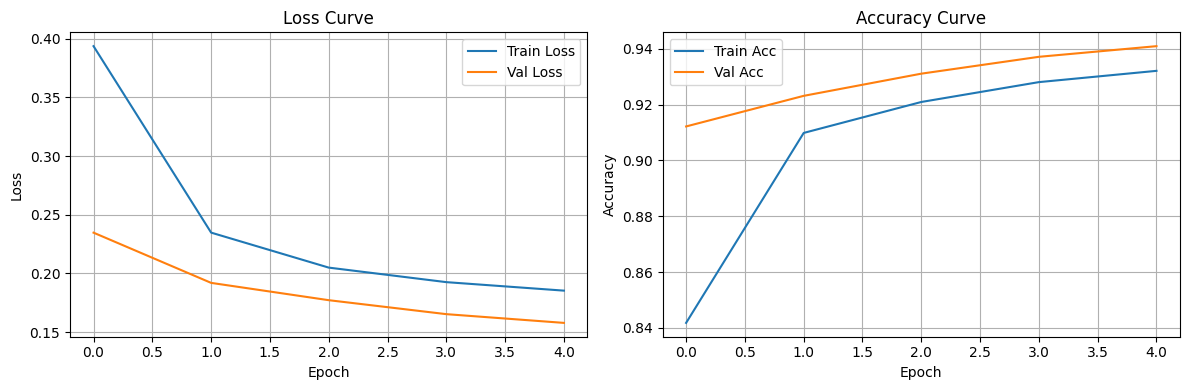

In [ ]:
# visulaizing the difference in training and validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()

# visulaizing the difference in training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

##5. Results and Comparisions

###1. Results of CNN Model

In [18]:
# Evaluating the model predictions on test data
test_preds_probs = model.predict(test, verbose=1)
test_preds = (test_preds_probs > 0.5).astype(int).flatten()

# Get true labels
true_labels = test.classes

# Using Classification Evaluation Metrics
acc = accuracy_score(true_labels, test_preds)
prec = precision_score(true_labels, test_preds)
rec = recall_score(true_labels, test_preds)
f1 = f1_score(true_labels, test_preds)
roc_auc = roc_auc_score(true_labels, test_preds_probs)

print(f"Performance of Custom CNN")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 594ms/step
Performance of Custom CNN
Accuracy:  0.9627
Precision: 0.9619
Recall:    0.9710
F1-score:  0.9664
ROC AUC:   0.9932


In [21]:
print(classification_report(true_labels, test_preds))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2820
           1       0.96      0.97      0.97      3480

    accuracy                           0.96      6300
   macro avg       0.96      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300



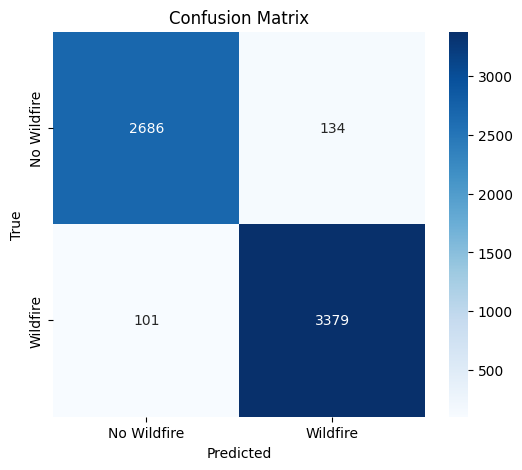

In [19]:
# CNN Performance Evaluation using confusion matrix
cm = confusion_matrix(true_labels, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


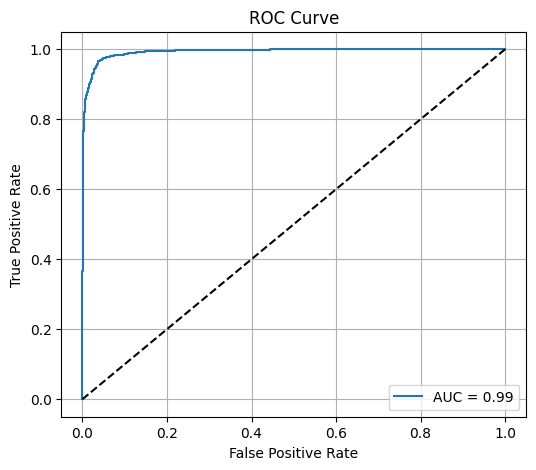

In [20]:
# CNN ROC Curve to find out the rate of true predictions against false predictions
fpr, tpr, thresholds = roc_curve(true_labels, test_preds_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid()
plt.show()


###2. Results of Pretrained VGG16

In [ ]:
# Evaluating teh pretrained model predictions on test data
test_preds_probs = model.predict(test)
test_preds = (test_preds_probs > 0.5).astype(int)
true_labels = test.classes

print(classification_report(true_labels, test_preds))

50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2820
           1       0.96      0.96      0.96      3480

    accuracy                           0.96      6300
   macro avg       0.96      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300



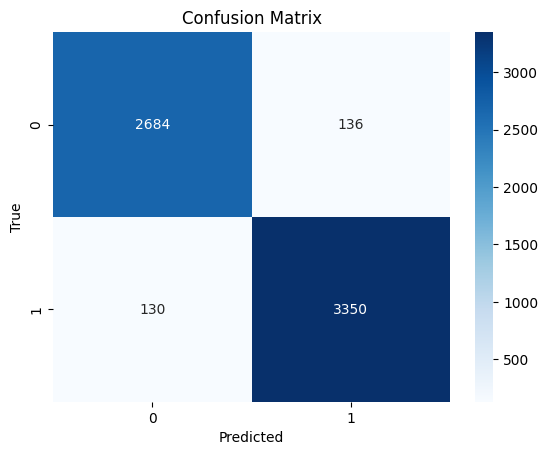

In [ ]:
# Confusion matrix for the pretrained VGG16
cm = confusion_matrix(true_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


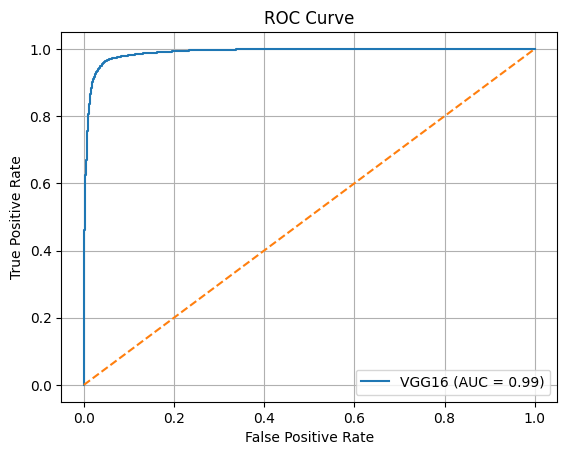

In [ ]:
# ROC Curve for the VGG16 Model
fpr, tpr, _ = roc_curve(true_labels, test_preds_probs)
roc_auc = roc_auc_score(true_labels, test_preds_probs)

plt.figure()
plt.plot(fpr, tpr, label='VGG16 (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
